In [1]:
import npu

In [2]:
%%kernel

void mmul(uint8_t * __restrict pA, uint8_t * __restrict pB, uint8_t * __restrict pC,
          unsigned rowA, unsigned colA, unsigned colB)
{   
    const int M = 4;
    const int K = 8;
    const int N = 4;
    using MMUL = ::aie::mmul<M, K, N, uint8_t, uint8_t>;
    
    for (unsigned z = 0; z < rowA; z += 2) chess_loop_range(2,) {
        uint8_t * __restrict pC1 = pC + (      z * colB +       0) * MMUL::size_C;
        uint8_t * __restrict pC2 = pC + ((z + 1) * colB +       0) * MMUL::size_C;     
        for (unsigned j = 0; j < colB; j += 2) chess_loop_range(2,) {
            const uint8_t * __restrict pA1 = pA + (      z * colA +       0) * MMUL::size_A;
            const uint8_t * __restrict pA2 = pA + ((z + 1) * colA +       0) * MMUL::size_A;
            const uint8_t * __restrict pB1 = pB + (      0 * colB +       j) * MMUL::size_B;
            const uint8_t * __restrict pB2 = pB + (      0 * colB + (j + 1)) * MMUL::size_B;
            ::aie::vector<uint8_t, MMUL::size_A> A0 = ::aie::load_v<MMUL::size_A>(pA1); 
            pA1 += MMUL::size_A;
            ::aie::vector<uint8_t, MMUL::size_A> A1 = ::aie::load_v<MMUL::size_A>(pA2); 
            pA2 += MMUL::size_A;
            ::aie::vector<uint8_t, MMUL::size_B> B0 = ::aie::load_v<MMUL::size_B>(pB1); 
            pB1 += MMUL::size_B * colB;
            ::aie::vector<uint8_t, MMUL::size_B> B1 = ::aie::load_v<MMUL::size_B>(pB2); 
            pB2 += MMUL::size_B * colB;
            
            MMUL C00; 
            C00.mul(A0, B0);
            MMUL C01; 
            C01.mul(A0, B1);
            MMUL C10; 
            C10.mul(A1, B0);
            MMUL C11; 
            C11.mul(A1, B1);
            
            for (unsigned i = 1; i < colA; ++i) chess_prepare_for_pipelining chess_loop_range(3,) {
                A0 = ::aie::load_v<MMUL::size_A>(pA1); 
                pA1 += MMUL::size_A;
                A1 = ::aie::load_v<MMUL::size_A>(pA2);
                pA2 += MMUL::size_A;
                B0 = ::aie::load_v<MMUL::size_B>(pB1); 
                pB1 += MMUL::size_B * colB;
                B1 = ::aie::load_v<MMUL::size_B>(pB2); 
                pB2 += MMUL::size_B * colB;
                
                C00.mac(A0, B0);
                C01.mac(A0, B1);
                C10.mac(A1, B0);
                C11.mac(A1, B1);
            }

            ::aie::store_v(pC1, C00.template to_vector<uint8_t>()); 
            pC1 += MMUL::size_C;
            ::aie::store_v(pC1, C01.template to_vector<uint8_t>()); 
            pC1 += MMUL::size_C;
            ::aie::store_v(pC2, C10.template to_vector<uint8_t>()); 
            pC2 += MMUL::size_C;
            ::aie::store_v(pC2, C11.template to_vector<uint8_t>()); 
            pC2 += MMUL::size_C;
        }
    }
}

In [3]:
# Check the kernel has been created and is a Kernel type
mmul

In [4]:
# Check the kernel source code
print(mmul.srccode)


#define NOCPP
#include <stdint.h>
#include <stdio.h>
#include <stdlib.h>
#define REL_WRITE 0
#define REL_READ 1
#include <aie_api/aie.hpp>

        

extern "C" {
void mmul(uint8_t * __restrict pA, uint8_t * __restrict pB, uint8_t * __restrict pC,
          unsigned rowA, unsigned colA, unsigned colB)
{   
    const int M = 4;
    const int K = 8;
    const int N = 4;
    using MMUL = ::aie::mmul<M, K, N, uint8_t, uint8_t>;
    
    for (unsigned z = 0; z < rowA; z += 2) chess_loop_range(2,) {
        uint8_t * __restrict pC1 = pC + (      z * colB +       0) * MMUL::size_C;
        uint8_t * __restrict pC2 = pC + ((z + 1) * colB +       0) * MMUL::size_C;     
        for (unsigned j = 0; j < colB; j += 2) chess_loop_range(2,) {
            const uint8_t * __restrict pA1 = pA + (      z * colA +       0) * MMUL::size_A;
            const uint8_t * __restrict pA2 = pA + ((z + 1) * colA +       0) * MMUL::size_A;
            const uint8_t * __restrict pB1 = pB + (      0 * colB +      

In [5]:
# Check the buffers that were created
mmul.metadata

{'name': 'mmul_0',
 'tloc': None,
 'ttype': 'CT',
 'ktype': 'mmul',
 'type': 'CT',
 'ports': {'pA': {'c_dtype': None,
   'direction': None,
   'name': 'pA',
   'ctype': None,
   'shape': None,
   'dtype': None},
  'pB': {'c_dtype': None,
   'direction': None,
   'name': 'pB',
   'ctype': None,
   'shape': None,
   'dtype': None},
  'pC': {'c_dtype': None,
   'direction': None,
   'name': 'pC',
   'ctype': None,
   'shape': None,
   'dtype': None},
  'rowA': {'c_dtype': 'unsigned',
   'direction': 'in',
   'name': 'rowA',
   'ctype': 'rtp',
   'value': 'unsigned'},
  'colA': {'c_dtype': 'unsigned',
   'direction': 'in',
   'name': 'colA',
   'ctype': 'rtp',
   'value': 'unsigned'},
  'colB': {'c_dtype': 'unsigned',
   'direction': 'in',
   'name': 'colB',
   'ctype': 'rtp',
   'value': 'unsigned'}}}

In [6]:
import numpy as np

from npu.build.appbuilder import AppBuilder
from npu.build.kernel import Kernel
from npu.build.itkernel import ITWrite, ITRead


class SmallMtxMul(AppBuilder):

    def __init__(self, kernel: Kernel):
        self.kernel = kernel
        super().__init__()

    def callgraph(self, mtx_a: np.ndarray, mtx_b: np.ndarray, mtx_c: np.ndarray,
                 M: int, K: int, N: int) -> None:
        input_a = ITRead(mtx_a)
        input_b = ITRead(mtx_b)
        kernel_output = self.kernel(input_a, input_b, mtx_a.shape[0] // M, mtx_a.shape[1] // K, mtx_b.shape[1] // N)
        _ = ITWrite(kernel_output, bufref=mtx_c)

In [7]:
import numpy as np

from npu.build.appbuilder import AppBuilder
from npu.build.kernel import Kernel

# Create an instance of the applicaiton
app_builder = SmallMtxMul(kernel=mmul)

# Trace the callgraph
mtx_a = np.zeros(shape=(64, 64), dtype=np.uint8)
mtx_b = np.zeros(shape=(64, 64), dtype=np.uint8)
mtx_c = np.zeros(shape=(64, 64), dtype=np.uint8)
M = 4;
K = 8;
N = 4;

# Define array size of pC to help the compiler determine the shape of the buffer
# Skipping this could cause a RuntimeError
app_builder.kernel.pC.array = np.ndarray(shape=(64, 64), dtype=np.uint8)
app_builder(mtx_a, mtx_b, mtx_c, M, K, N)

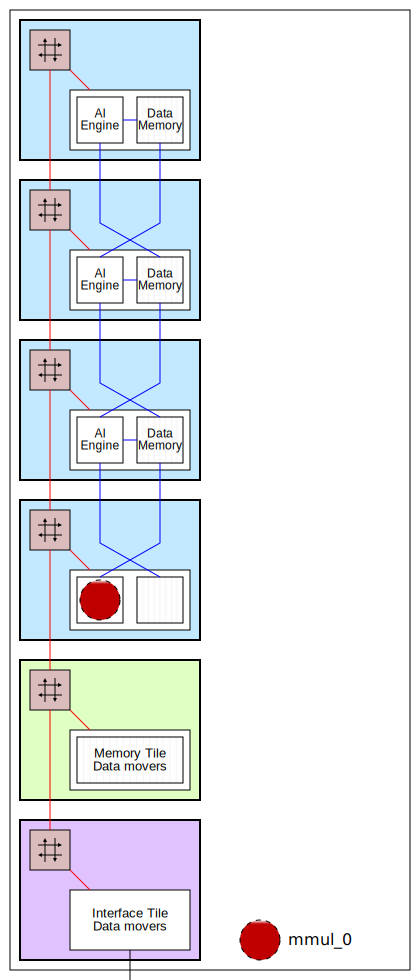

In [8]:
app_builder.display()

In [9]:
app_builder.build(mtx_a, mtx_b, mtx_c, M, K, N)

Using cached mmul kernel object file...
Building the xclbin...
Successfully Building Application... SmallMtxMul.xclbin & SmallMtxMul.seq delivered


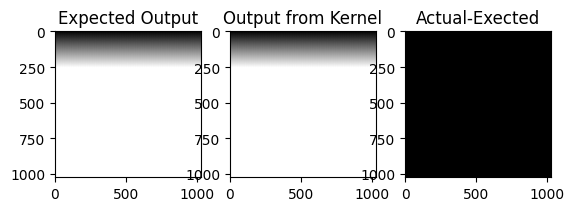

Checking for error in kernel calculation: Min(Actual-Expected)= 0 Max(Actual-Expected)= 0
total kernel time (without tiling overhead)= 1.43927001953125
total kernel time (with tiling overhead)= 1.7915406227111816
total cpu calculation time= 5.474603652954102


In [10]:
import numpy as np
import time

import matplotlib.pyplot as plt
from npu.runtime import AppRunner


def partition_matrix(matrix, tile_size):
    rows, cols = matrix.shape
    tile_rows, tile_cols = tile_size
    tiled_matrix = (matrix.reshape(rows // tile_rows, tile_rows, cols // tile_cols, tile_cols).
            swapaxes(1, 2))
    # Flatten the tiled matrix back to the original shape
    return tiled_matrix.reshape(rows, cols)
    

app = AppRunner('SmallMtxMul.xclbin')

# Allocate app input and output buffers to exchange data with NPU
input_a = app.allocate(shape=(64,64), dtype=np.uint8)
input_b = app.allocate(shape=(64,64), dtype=np.uint8)
output_c = app.allocate(shape=(64,64), dtype=np.uint8)

# Load array into input buffer
dim = 1024
M = 4;
K = 8;
N = 4;
scaling_factors = np.arange(0, dim)  # Diagonal elements from 0 to dim-1
# Threshold the scaling factor since the arrays are uint8
threshold = 2**8-1
a = np.diag(scaling_factors)
a = np.where(a > threshold, 255, a)
b = np.ones(shape=(dim,dim), dtype=np.uint8)
c = np.zeros(shape=(dim,dim), dtype=np.uint8)
absolute_start = time.time()
total_time = time.time()-time.time()
for row_a in range(0, a.shape[0], 64):
    for col_b in range(0, b.shape[1], 64):
        for col_a in range(0, a.shape[1], 64):
            a_tiled = partition_matrix(a[row_a:row_a+64,col_a:col_a+64], (M,K))
            b_tiled = partition_matrix(b[col_a:col_a+64,col_b:col_b+64], (K,N))
            input_a[:] = a_tiled
            input_b[:] = b_tiled
            # Pass input_image buffer to NPU
            input_a.sync_to_npu()
            input_b.sync_to_npu()

            # Run app on NPU
            start = time.time()
            app.call(input_a, input_b, output_c)
            total_time = total_time + (time.time() - start)

            # Get results from NPU via output_image buffer
            output_c.sync_from_npu()
            c[row_a:row_a+64,col_b:col_b+64] = c[row_a:row_a+64,col_b:col_b+64] + np.array(output_c)
absolute_total_time = time.time() - absolute_start

# Create a figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

# Otain the CPU calculation time. Don't store in an object here
# because the calculation time will go to 0 after the first
# calculation if stored in an object.
start = time.time()
a@b
total_cpu_time = time.time() - start
expected_output = partition_matrix(a@b, (4,4))

# Display the images. Tile the axb since the output from
# the kernel will be tiled.
ax1.imshow(expected_output, cmap='gray')
ax1.set_title('Expected Output')

ax2.imshow(c, cmap='gray')
ax2.set_title('Output from Kernel')

ax3.imshow(c-expected_output, cmap='gray')
ax3.set_title('Actual-Exected')

# Show the plot
plt.show()

print('Checking for error in kernel calculation: Min(Actual-Expected)=', np.min(c-expected_output), 'Max(Actual-Expected)=', np.max(c-expected_output))
print('total kernel time (without tiling overhead)=', total_time)
print('total kernel time (with tiling overhead)=', absolute_total_time)
print('total cpu calculation time=', total_cpu_time)

In [11]:
del app